# <center>TMVA Classification Using Deep Neural Networks</center>

In this notebook we still classify di-Higgs new data with Deep Neural Networks meethod.

In [1]:
import ROOT
from ROOT import TMVA, TTree

ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

Welcome to JupyROOT 6.14/04


### Filter dataset by region.

This function will let you filter your dataset by region. It's known that SR_1tag is very signal poor, while SR_2tag has a lot a signal.

In [2]:
def filter_region(file, region, newfile):
    oldfile = ROOT.TFile(file)
    oldtree = oldfile.Nominal
    newfile = ROOT.TFile(newfile,"recreate")
    newtree = oldtree.CloneTree(0)
    for entry in oldtree:
        if (entry.m_region == region):
            newtree.Fill()
    
    newtree.AutoSave()   
    return newtree, newfile

#Use as
#tree, file = filter_region("data.root", "SR_1tag", "small.root")

## Declare Factory and Input Data

data.root has unlabeled data points (called data) and fakes points. For the background training we'll use only the fakes points.

In [3]:
oldtree, oldfile = filter_region("data.root", "SR_1tag", "data_f.root")

newfile = ROOT.TFile("small.root","recreate")
backgroundTreeB1 = oldtree.CloneTree(0)

for entry in oldtree:
    sample = entry.sample
    reg = entry.m_region
    if (sample == 'fakes'):
        backgroundTreeB1.Fill()

backgroundTreeB1.AutoSave()

153148

In [4]:
outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

# Input data
# We define now the input data file and we retrieve the ROOT TTree objects with the signal and background input events
#signalTree1, inputFileS1 = filter_region("Xtohh1000.root", "SR_1tag", "Xtohh1000_f.root")
signalTree2, inputFileS2 = filter_region("Xtohh2000.root", "SR_1tag", "Xtohh2000_f.root")
backgroundTreeB2, inputFileB2 = filter_region("stop.root", "SR_1tag", "stop_f.root")
backgroundTreeB3, inputFileB3 = filter_region("ttbar.root", "SR_1tag", "ttbar_f.root")
backgroundTreeB4, inputFileB4 = filter_region("W+jets.root", "SR_1tag", "W+jets_f.root")
backgroundTreeB5, inputFileB5 = filter_region("Zee_221.root", "SR_1tag", "Zee_221_f.root")
backgroundTreeB6, inputFileB6 = filter_region("Ztautau_221.root", "SR_1tag", "Ztautau_221_f.root")
backgroundTreeB7, inputFileB7 = filter_region("ZZ_Pw.root", "SR_1tag", "ZZ_Pw_f.root")

backgroundTreeB1.Print()

******************************************************************************
*Tree    :Nominal   : Nominal                                                *
*Entries :     2577 : Total =          255548 bytes  File  Size =     158982 *
*        :          : Tree compression factor =   8.04                       *
******************************************************************************
*Br    0 :sample    : string                                                 *
*Entries :     2577 : Total  Size=      26523 bytes  File Size  =       3320 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   6.89     *
*............................................................................*
*Br    1 :EventWeight : EventWeight/F                                        *
*Entries :     2577 : Total  Size=      10995 bytes  One basket in memory    *
*Baskets :        0 : Basket Size=      32000 bytes  Compression=   1.00     *
*...................................................

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

We have two kinds of signals and for the training we have to use only one of them.

In [5]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
#loader.AddSignalTree    ( signalTree1,     signalWeight     )
loader.AddSignalTree    ( signalTree2,     signalWeight     )
loader.AddBackgroundTree( backgroundTreeB1, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB2, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB3, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB4, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB5, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB6, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB7, backgroundWeight )

not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

## Define input variables 
for branch in backgroundTreeB1.GetListOfBranches():
    if branch.GetName() in not_cons:
        continue
    loader.AddVariable(branch.GetName())

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Nominal of type Signal with 9355 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Nominal of type Background with 2577 events
                         : Add Tree Nominal of type Background with 127 events
                         : Add Tree Nominal of type Background with 695 events
                         : Add Tree Nominal of type Background with 1140 events
                         : Add Tree Nominal of type Background with 275 events
                         : Add Tree Nominal of type Background with 4403 events
                         : Add Tree Nominal of type Background with 45 events


## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.

In [6]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";

loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=8000:nTrain_Background=8000:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## DNN

In [7]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [8]:
# Define model
model = Sequential()
model.add(Dense(64, kernel_initializer='glorot_normal', activation='sigmoid', input_dim=10))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))

# Set loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy',])

# Store model to file
model.save('model_dense.h5')

# Print summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 13,314
Trainable params: 13,314
Non-trainable params: 0
_________________________________________________________________


In [9]:
factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, 'Keras_Dense',
        'H:!V:VarTransform=G:FilenameModel=model_dense.h5:'+\
        'NumEpochs=10:BatchSize=16:TriesEarlyStopping=10')

<ROOT.TMVA::MethodPyKeras object ("Keras_Dense") at 0xacd5b30>

Factory                  : Booking method: Keras_Dense
                         : 
Keras_Dense              : [dataset] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_FJpt' <---> Output : variable 'm_FJpt'
                         : Input : variable 'm_FJm' <---> Output : variable 'm_FJm'
                         : Input : variable 'm_DTpt' <---> Output : variable 'm_DTpt'
                         : Input : variable 'm_DTm' <---> Output : variable 'm_DTm'
                         : Input : variable 'm_dPhiFTwDT' <---> Output : variable 'm_dPhiFTwDT'
                         : Input : variable 'm_dRFJwDT' <---> Output : variable 'm_dRFJwDT'
                         : Input : variable 'm_dPhiDTwMET' <---> Output : variable 'm_dPhiDTwMET'
                         : Input : variable 'm_MET' <---> Output : variable 'm_MET'
                   

## Train Model

In [10]:
factory.TrainAllMethods()

/home/andrea/anaconda3/lib/python3.5/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 16000 samples, validate on 2617 samples
Epoch 1/10
16000/16000 [==============================] - 4s 262us/step - loss: 0.3749 - categorical_accuracy: 0.8373 - val_loss: 0.3406 - val_categorical_accuracy: 0.8586

Epoch 00001: val_loss improved from inf to 0.34062, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 2/10
16000/16000 [==============================] - 4s 240us/step - loss: 0.3050 - categorical_accuracy: 0.8697 - val_loss: 0.3032 - val_categorical_accuracy: 0.8758

Epoch 00002: val_loss improved from 0.34062 to 0.30318, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 3/10
16000/16000 [==============================] - 3s 204us/step - loss: 0.2856 - categorical_accuracy: 0.8783 - val_loss: 0.3088 - val_categorical_accuracy: 0.8674

Epoch 00003: val_loss did not improve from 0.30318
Epoch 4/10
16000/16000 [==============================] - 3s 206us/step - loss: 0.2742 - categorical_accuracy: 0.8887 - val_loss: 0.3285 - val_categorica

## Test  Model

Here we test all methods using the test data set

In [11]:
factory.TestAllMethods()

Factory                  : Test all methods
Factory                  : Test method: Keras_Dense for Classification performance
                         : 
                         : Load model from file: dataset/weights/TrainedModel_Keras_Dense.h5


## Evaluate Model

Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc.. using both training and tetsing data sets. Several histograms are produced which can be examined with the TMVAGui or directly using the output file

In [12]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: Keras_Dense
                         : 
TFHandler_Keras_Dense    :     Variable            Mean            RMS    [        Min            Max ]
                         : -------------------------------------------------------------------------------
                         :       m_FJpt:      0.037000       0.98487   [       -3.0548        5.7307 ]
                         :        m_FJm:     0.0068906       0.99347   [       -3.0857        3.7585 ]
                         :       m_DTpt:      0.035097        1.0143   [       -3.1073        5.7307 ]
                         :        m_DTm:      0.029885        1.0213   [       -3.0739        3.3749 ]
                         :  m_dPhiFTwDT:     0.0064770        1.0064   [       -3.1209        5.7307 ]
                         :    m_dRFJwDT:      0.016210        1.0022   [       -3.1742        3.2877 ]
                         : m_dPhiDT

## Plot ROC Curve
We enable JavaScript visualisation for the plots

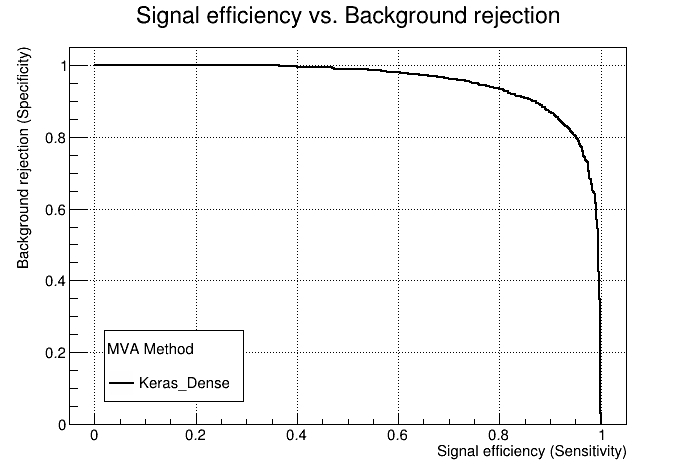

In [13]:
c1 = factory.GetROCCurve(loader)
c1.Draw()

To do:
* Aclarar cómo afecta el peso al modelo.
* Clasificar los puntos de datos.
* Aclarar cómo se va a medir la performance de los modelos.